This File sets up the large Multi-Modal discriminator model which is compromised of a visual model (ViT), Transformer-based embeddings for the textual data and fully connected layers.



Note that the execution of this notebook requires a lot of RAM and GPU RAM.

Using pandas > 2.0.0 is imcompatible!

In [ ]:
!pip install transformers
!pip install miceforest
!pip install sentence_transformers
!pip install accelerate
#!pip install pinecone-client
#!pip install -qU pinecone-client pandas
#!pip install pandas==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import json
import cv2
from tqdm.auto import tqdm
from accelerate import Accelerator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from transformers import AutoTokenizer, AutoModel

In [ ]:
# connecting to drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
## reading in tabuar data

import pandas as pd
airbnb_london_filtered_images = pd.read_csv("/content/gdrive/My Drive/Thesis/London_Data/discriminator_tabular_data_images.csv")

In [ ]:
## Functions ## - only needs to be called when when re-coding the the set up of the final data frame (airbnb_london_filtered_images_imp_var) used in the traiing which can also be read in from drive


re_code_airbnb_london_filtered_images_imp_var = False

if re_code_airbnb_london_filtered_images_imp_var == True:

  import miceforest as mf

  def cat_to_numeric(col: pd.Series) -> pd.Series:
    """ Self-explanatory"""

    col = pd.Categorical(col)
    col = col.codes
    return col

  def apply_gbm_impute(df: pd.DataFrame, iterations: int) -> pd.DataFrame:
    """ Function to automatically apply imputating based on LightGB  """

    kds = mf.ImputationKernel(
    df,
    save_all_iterations=True,
    random_state=100)

    kds.mice(iterations)
    df_imputed = kds.complete_data()

    return df_imputed




In [ ]:
class Simple_Dataset(Dataset):

    ''' This class transforms the input data to a useable dataset, which can be passed
    to PyTorch's dataloader class in a very generic fashion. The collate function needs to
    actually define the variables here!'''

    def __init__(self, df):
        # also defining default value #

        # data as Pytorch tensors via the collate batches function
        self.data = np.array(df)

    def __getitem__(self, idx):
        return (self.data[idx])

    def __len__(self):
        return(self.data.shape[0])


## Preparing the Visual Sub-Model

The images shall be embedded through a pre-trained Visual Transformer Model (fine-tuned on hotel images) and thus need to be passed through the corresponding Extractor Function (e.g. for image resizing and normalization).

The final embeddings (ie the last hidden state) shall be saved in an external vector database in the formal of a json file that can be read back in (professional external vector dabaase providers are too expensive!)



Set create_external_vector_database_images to true if that db must be created, else to false!

In [ ]:
create_external_vector_database_images = False

In [ ]:
if create_external_vector_database_images == True:

  from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TFViTModel

  extractor = AutoFeatureExtractor.from_pretrained("faisalabidi/hotel-image-classifier")
  visual_model = AutoModelForImageClassification.from_pretrained("faisalabidi/hotel-image-classifier")

  ## Importantly, only using tthe last hidden state, not the final layer used for classification.
  model_vit = visual_model.vit

  device = "cuda"
  model_vit = model_vit.to(device)

  dict_images = {}

  # loopf for upserting into database
  for idx in range(airbnb_london_filtered_images.shape[0]):

    #print(idx/airbnb_london_filtered_images.shape[0])

    id = airbnb_london_filtered_images.id[idx]
    img_current = cv2.imread(f"/content/gdrive/My Drive/Thesis/Image_data/img_{id}.jpg")

    # aplply extractor function
    extracted = torch.tensor(extractor(img_current)['pixel_values'])

    # apply model
    output = model_vit(extracted.to(device))

    # get last hidden state and mean across dim 1
    last_hd_1 = output.last_hidden_state  ##.shape
    last_hd = torch.mean(last_hd_1, dim = 1)
    last_hd_list = list(last_hd)[0].tolist()

    dict_images[int(id)] = last_hd_list

    if idx % 200 == 0:
      x = json.dumps(dict_images)
      with open("/content/gdrive/My Drive/Thesis/Image_data/json_images.json", 'w') as f:
        f.write(x)

  x = json.dumps(dict_images)
  with open("/content/gdrive/My Drive/Thesis/Image_data/json_images.json", 'w') as f:
    f.write(x)

The last layer is only used for classification purposes and shall thus not be used here.

## Preparing the Textual Sub-Model

After experimentation with different models, including task-related pretrained models, I have decided to go with an SBERT model for the encoding of both the Name and the description. This model is finetuned to fit the specific vocabulary in a different notebook and can be read in. Also, I found that having a joint description of both the actual description and the space description works best. This also works because the joint description does not exceed the maximum number of input tokens.

In [ ]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, models


Set create_external_vector_database_texts to true to create the external vector databases for the name and the description again.

In [ ]:
create_external_vector_database_texts = False


In [ ]:
if create_external_vector_database_texts == True:


  ## reading in fine-tnuned SBERT model
  model_save_name = 'sbert_tuned.pth'
  path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)

  model_sbert = torch.load(path)

  ## no setting up database
  airbnb_london_filtered_images.neighborhood_overview = airbnb_london_filtered_images.neighborhood_overview.fillna("No description")
  airbnb_london_filtered_images["joint_description"] = airbnb_london_filtered_images.description + " . " + airbnb_london_filtered_images.neighborhood_overview

  dict_names = {}
  dict_des = {}

  device = "cuda"
  model_sbert = model_sbert.to(device)

  ## loop for upserting into both vector databases

  for idx in range(airbnb_london_filtered_images.shape[0]):

    #print(idx/airbnb_london_filtered_images.shape[0])

    id = airbnb_london_filtered_images.id[idx]

    des_1 = model_sbert.encode(airbnb_london_filtered_images.joint_description[idx])
    des = des_1.tolist()

    name_1 = model_sbert.encode(airbnb_london_filtered_images.name[idx])
    name = name_1.tolist()

    dict_names[int(id)] = name
    dict_des[int(id)] = des

    if idx % 200 == 0:
      x = json.dumps(dict_des)
      with open("/content/gdrive/My Drive/Thesis/London_Data/json_des.json", 'w') as f:
        f.write(x)

      y = json.dumps(dict_names)
      with open("/content/gdrive/My Drive/Thesis/London_Data/json_name.json", 'w') as f:
        f.write(y)

  if idx % 200 == 0:
    x = json.dumps(dict_des)
    with open("/content/gdrive/My Drive/Thesis/London_Data/json_des.json", 'w') as f:
      f.write(x)

    y = json.dumps(dict_names)
    with open("/content/gdrive/My Drive/Thesis/London_Data/json_name.json", 'w') as f:
      f.write(y)

else:
  pass


## Model-based decision on which features to use

I shall let a model decide on the most important tabluar features to include the the multi-modal model. More specifically, XGBoost (Extreme Gradient Boosting) was utilized. These are then used in the MM Model alongside the main image, the name and the joint description.

Important: All these steps need not be executed twice as the DF airbnb_london_filtered_images_imp_var can just be loaded in (see below).

In [ ]:
## listing all potential logical tabular confounders

#print(airbnb_london_filtered_images.columns[:60])
#print(airbnb_london_filtered_images.columns[60:])


## list of these - including other variabls that will be needed later on like id, name, outcome variables ...
pot_confounders = ['id', 'name', 'description', 'neighborhood_overview',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'in_inner_boundary', 'price_per_accomodate',
       'has_amenity_Wifi', 'has_amenity_Essentials', 'has_amenity_Kitchen',
       'has_amenity_Heating', 'has_amenity_Smoke alarm', 'has_amenity_Washer',
       'has_amenity_Hangers', 'has_amenity_Long term stays allowed',
       'has_amenity_Iron', 'has_amenity_Hair dryer', 'has_amenity_Shampoo',
       'has_amenity_Hot water', 'has_amenity_Carbon monoxide alarm',
       'has_amenity_Dishes and silverware', 'has_amenity_Refrigerator',
       'has_amenity_TV', 'has_amenity_Cooking basics',
       'has_amenity_Bed linens', 'has_amenity_Oven', 'has_amenity_Microwave',
       'has_amenity_Dryer', 'has_amenity_Stove', 'has_amenity_First aid kit',
       'has_amenity_Fire extinguisher', 'has_amenity_Coffee maker',
       'has_amenity_Dishwasher', 'has_amenity_Private entrance',
       'has_amenity_Extra pillows and blankets', 'has_amenity_Elevator',
       'has_amenity_Host greets you', 'has_amenity_Free parking on premises',
       'len_amenities', 'len_description', 'proxy', 'review_diff']

In [ ]:
airbnb_london_filtered_images_pot_conf = airbnb_london_filtered_images[pot_confounders]


Checking for NaNs to know which columns are unusable andd fir which dropping these are imputing might make sense

In [ ]:
print(airbnb_london_filtered_images_pot_conf.isna().sum()[0:30])
print(airbnb_london_filtered_images_pot_conf.isna().sum()[30:])


id                                  0
name                                0
description                         0
neighborhood_overview            6828
host_response_time              12233
host_response_rate              12233
host_acceptance_rate            10998
host_is_superhost                   0
host_listings_count                 0
host_identity_verified              0
neighbourhood_cleansed              0
neighbourhood_group_cleansed    22570
room_type                           0
accommodates                        0
bathrooms                       22570
bedrooms                          976
beds                              267
price                               0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
number_of_reviews_ltm               0
review_scores_rating               67
review_scores_accuracy            657
review_scores_cleanliness         650
review_scores_checkin             683
review_score

I shall drop thoe variables with an extremely high number of NaNs as these are too many to impute and that would introduce too much noise. Also, I shall drop the variavbes concering the reviews like review_scores_accuracy etc as these are hard to impute from other vriables (unlike e.g. beds for which variables like the number of accomodates or the number of bedrooms are good indicators).

In [ ]:
to_drop = ["host_response_time","host_response_rate","host_acceptance_rate",
  "neighbourhood_group_cleansed", "bathrooms", "review_scores_accuracy",
  "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication",
  "review_scores_location","review_scores_value"]


airbnb_london_filtered_images_pot_conf = airbnb_london_filtered_images_pot_conf.drop(to_drop, axis = 1)

In [ ]:
## imputing for beds and bedrooms

airbnb_london_filtered_images_pot_conf.room_type = cat_to_numeric(airbnb_london_filtered_images_pot_conf.room_type).astype("int")
df_imputed = apply_gbm_impute(airbnb_london_filtered_images_pot_conf[['room_type', 'accommodates', 'bedrooms', 'beds']], 5)

airbnb_london_filtered_images_pot_conf["bedrooms"] = df_imputed["bedrooms"]
airbnb_london_filtered_images_pot_conf["beds"] = df_imputed["beds"]


Variables reviews_per_month and review_scores_rating might both be important aand hard to imput. Lets see if the NaNs in both variables (same number!) corrrelate

In [ ]:
## correlation of reviews_per_month and review_scores_rating

airbnb_london_filtered_images_pot_conf.reviews_per_month[airbnb_london_filtered_images_pot_conf.review_scores_rating.isna() == True].isna().sum()

# So perfect correlation in the NaNs -> dropping these datapoints


67

In [ ]:
airbnb_london_filtered_images_pot_conf = airbnb_london_filtered_images_pot_conf[airbnb_london_filtered_images_pot_conf.review_scores_rating.isna() == False]

Examining the data types and which categorical variables need to be mapped to continuous

In [ ]:
airbnb_london_filtered_images_pot_conf.dtypes

id                                          int64
name                                       object
description                                object
neighborhood_overview                      object
host_is_superhost                          object
host_listings_count                       float64
host_identity_verified                     object
neighbourhood_cleansed                     object
room_type                                   int64
accommodates                              float64
bedrooms                                  float64
beds                                      float64
price                                     float64
minimum_nights                            float64
maximum_nights                            float64
number_of_reviews                         float64
number_of_reviews_ltm                     float64
review_scores_rating                      float64
reviews_per_month                         float64
in_inner_boundary                           int64


In [ ]:
airbnb_london_filtered_images_pot_conf.host_is_superhost = cat_to_numeric(airbnb_london_filtered_images_pot_conf.host_is_superhost).astype("int")
airbnb_london_filtered_images_pot_conf.host_identity_verified = cat_to_numeric(airbnb_london_filtered_images_pot_conf.host_identity_verified).astype("int")

In [ ]:
dummies_neighborhood = pd.get_dummies(airbnb_london_filtered_images_pot_conf.neighbourhood_cleansed)


Applying XGBoost to determine features with predictive quality:

General idea: The greater the increase/decrease in the desired metric (here MSE) based on a split by the feature under consdieration (weighted by the number of datapoints being split) the more important that feature is deemed. This procedure is then averaged across all single trees.

Qute:  The Elements of Statistical Learning: Data Mining, Inference, and Prediction, page 367.

In [ ]:
# dropping object oof neighborhoods
airbnb_london_filtered_images_pot_conf = airbnb_london_filtered_images_pot_conf.drop("neighbourhood_cleansed", axis = 1 )

# concatiinating
airbnb_london_filtered_images_pot_conf = pd.concat([airbnb_london_filtered_images_pot_conf, dummies_neighborhood], axis = 1)

Using XGB for feature selection

In [ ]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance
from matplotlib import pyplot as plt


In [ ]:
## dropping non-tabukar data and outcomes
X_xgb = airbnb_london_filtered_images_pot_conf.drop(['id', 'name', 'description', 'neighborhood_overview', 'joint_description','proxy', 'review_diff'], axis = 1)
Y_xgb = airbnb_london_filtered_images_pot_conf["review_diff"]


In [ ]:
model_xgb = XGBRegressor()
model_xgb.fit(X_xgb, Y_xgb)

In [ ]:

df_imps = pd.DataFrame({"importances": model_xgb.feature_importances_, "features": X_xgb.columns}).sort_values(by=['importances'], ascending=False)
df_imps.to_csv("/content/gdrive/My Drive/Thesis/London_Data/df_feature_importances.csv", index = False)

print(df_imps.iloc[0:42])
print(df_imps.iloc[42:])


    importances                              features
11     0.242895                 number_of_reviews_ltm
3      0.040522                             room_type
13     0.038217                     reviews_per_month
24     0.025089                      has_amenity_Iron
78     0.018101                         Tower Hamlets
7      0.017029                                 price
8      0.015745                        minimum_nights
32     0.015585            has_amenity_Cooking basics
58     0.015396                               Enfield
68     0.015054                Kensington and Chelsea
67     0.014382                             Islington
80     0.013437                            Wandsworth
76     0.013260                             Southwark
44     0.013167                  has_amenity_Elevator
10     0.013015                     number_of_reviews
18     0.012951                   has_amenity_Kitchen
25     0.012628                has_amenity_Hair dryer
70     0.012228             

Keeping all but rather irrelvant featuress based on importances (see below). A treshold was decided on by experimentation and by logical reasoning given the variables correspodning to the tresholds.

In [ ]:
## keeping all but 'irrelevant' features

imp_features = df_imps.features[df_imps.importances >= 0.004451]

In [ ]:
airbnb_london_filtered_images_pot_conf_X = airbnb_london_filtered_images_pot_conf[imp_features]

## adding further variables needed for the model

airbnb_london_filtered_images_imp_var = pd.concat([airbnb_london_filtered_images_pot_conf_X, airbnb_london_filtered_images_pot_conf[["id", "name", "joint_description", "proxy", "review_diff"]] ], axis = 1)

In [ ]:
## saving this DF as it can also be used in the evaluation of the counterfactuals

airbnb_london_filtered_images_imp_var.to_csv("/content/gdrive/My Drive/Thesis/London_Data/airbnb_london_filtered_images_counterfactual_prep.csv", index = False)

**IMPORTNANT - If you want to re-run just the training, continue from here :)**

In [ ]:
airbnb_london_filtered_images_imp_var = pd.read_csv("/content/gdrive/My Drive/Thesis/London_Data/airbnb_london_filtered_images_counterfactual_prep.csv")


I shall only train the discriminator model on those datapoints which are important for the evluation, hence excluding the top third concerning the review differences. This is done as some values in the latter are extremely high, which leads to the duscriminator model not learning a very accurate mapping for the borrom two thirds concerning review difference.



In [ ]:
airbnb_london_filtered_images_imp_var.review_diff.mean()

4.515709016575568

In [ ]:
airbnb_london_filtered_images_imp_var[airbnb_london_filtered_images_imp_var.proxy !=3].review_diff.mean()

1.9148936170212767

In [ ]:
airbnb_london_filtered_images_imp_var[airbnb_london_filtered_images_imp_var.proxy==3].review_diff.mean()

16.926240888580352

In [ ]:
airbnb_london_filtered_images_imp_var = airbnb_london_filtered_images_imp_var[airbnb_london_filtered_images_imp_var.proxy != 3]

#### Now setting up the DaltaLoaders and the models

In [ ]:
airbnb_london_filtered_images_train = airbnb_london_filtered_images.sample(n = int( np.ceil(0.98*airbnb_london_filtered_images_imp_var.shape[0])), random_state = 100)
airbnb_london_filtered_images_eval = airbnb_london_filtered_images_imp_var.drop(airbnb_london_filtered_images_train.index, axis = 0)


In [ ]:
data_train = Simple_Dataset(airbnb_london_filtered_images_train)
data_eval = Simple_Dataset(airbnb_london_filtered_images_eval)


In [ ]:
# still change!!

for i,j in enumerate(airbnb_london_filtered_images_eval.columns):
  print(f"At position {str(i)} : variable {str(j)}")


At position 0 : variable number_of_reviews_ltm
At position 1 : variable room_type
At position 2 : variable reviews_per_month
At position 3 : variable has_amenity_Iron
At position 4 : variable Tower Hamlets
At position 5 : variable price
At position 6 : variable minimum_nights
At position 7 : variable has_amenity_Cooking basics
At position 8 : variable Enfield
At position 9 : variable Kensington and Chelsea
At position 10 : variable Islington
At position 11 : variable Wandsworth
At position 12 : variable Southwark
At position 13 : variable has_amenity_Elevator
At position 14 : variable number_of_reviews
At position 15 : variable has_amenity_Kitchen
At position 16 : variable has_amenity_Hair dryer
At position 17 : variable Lambeth
At position 18 : variable bedrooms
At position 19 : variable has_amenity_Refrigerator
At position 20 : variable Newham
At position 21 : variable has_amenity_Heating
At position 22 : variable has_amenity_Hot water
At position 23 : variable len_description
At pos

In [ ]:
# may take some time - and needs to be called 2 times sometimes as first run fails for some reason!

with open("/content/gdrive/My Drive/Thesis/London_Data/json_names.json") as json_data:
    dict_names = json.load(json_data)

with open("/content/gdrive/My Drive/Thesis/London_Data/json_des.json") as json_data:
    dict_des = json.load(json_data)


with open("/content/gdrive/My Drive/Thesis/Image_data/json_images.json") as json_data:
    dict_images = json.load(json_data)



In [ ]:
def collate_batch_extended(batch):

  list_images = []   # for the images passed through extractor function
  tabular_list = []
  list_proxies = []
  list_review_diff = []
  list_name = []
  list_joint_description = []
  list_ids = []

  for data in batch:

    # indexing the image pixels form the dict
    list_images.append(dict_images[str(data[62])])

    list_ids.append(data[62]) # for saving the predictions

    tabular_list.append(data[:62]) ## locations of tabular data
    if int(data[65]) == 1:  ## location of categorical proxy variable
      list_proxies.append([1,0,0])
    elif int(data[65]) == 2:
      list_proxies.append([0,1,0])
    elif int(data[65]) == 3:
      list_proxies.append([0,0,1])

    list_review_diff.append(data[66])  ## location of cont. review diff variable

    list_joint_description.append(dict_des[str(data[62])])
    list_name.append(dict_names[str(data[62])])


  list_images  = torch.tensor(list_images, dtype=torch.float32)
  list_joint_description = torch.tensor(list_joint_description, dtype=torch.float32)
  list_name = torch.tensor(list_name, dtype=torch.float32)
  tabular_list = torch.tensor(tabular_list, dtype=torch.float32)
  list_proxies = torch.tensor(list_proxies, dtype=torch.float32)

  return list_images, list_name, list_joint_description, tabular_list, list_proxies, list_review_diff, list_ids


# images, names, des, tabular data, proxies, review_diff, ids


In [ ]:
dl_train = DataLoader(dataset=data_train, collate_fn=collate_batch_extended, batch_size=64, shuffle=True)
dl_eval = DataLoader(dataset=data_eval, collate_fn=collate_batch_extended, batch_size=64, shuffle=False)


Calling the model again with a slightlxy different set up which proved to work well.

In [ ]:

import torch
from torch import nn
from torch import optim

tab_input_dim = 62
final_output_dim_text_name = 2
final_output_dim_text_des = 2
final_output_dim_visual = 2

hidden_dim_1 = 60
hidden_dim_2 = 60
hidden_dim_3 = 50
hidden_dim_4 = 20

output_dim = 1


## name, des / text model


class NeuralNetwork2(nn.Module): ## without extractor
    def __init__(self, tab_input_dim, final_output_dim_visual , final_output_dim_text_name, final_output_dim_text_des, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim):
        super(NeuralNetwork2, self).__init__()


        # layers build on top of visual model before concatination
        self.visual_add_layer_1 = nn.Linear(768, 100)
        self.visual_add_layer_2 = nn.Linear(100, 100)
        self.visual_add_layer_3 = nn.Linear(100, 50)
        self.visual_add_layer_4 = nn.Linear(50, final_output_dim_visual)

        # Layers added after Name/Title
        self.name_added_layer_1 = nn.Linear(768, 100)
        self.name_added_layer_2 = nn.Linear(100, 100)
        ### dropout ##
        self.name_added_layer_3 = nn.Linear(100, 50)
        self.name_added_layer_4 = nn.Linear(50, final_output_dim_text_name)

        # Layers added after Description
        self.des_added_layer_1 = nn.Linear(768, 100)
        self.des_added_layer_2 = nn.Linear(100, 100)
        ### dropout ##
        self.des_added_layer_3 = nn.Linear(100, 50)
        self.des_added_layer_4 = nn.Linear(50, final_output_dim_text_des)


        ### Layers added after Joint Description ###

        # dimension after concat operation
        self.concat_dim = tab_input_dim + final_output_dim_visual + final_output_dim_text_name + final_output_dim_text_des

        # layers processing input after concatination
        self.layer_1 = nn.Linear(self.concat_dim, hidden_dim_1)
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.layer_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.layer_4 = nn.Linear(hidden_dim_3, hidden_dim_4)
        self.layer_5 = nn.Linear(hidden_dim_4, output_dim)

        # Regu features
        self.dropout = nn.Dropout(0.03)
        self.batch_norm_1 = nn.BatchNorm1d(hidden_dim_2) # 1-dim batch norm with covariance-shift params activated
        self.batch_norm_2 = nn.BatchNorm1d(hidden_dim_3)



    def forward(self, img_encoded, name_encoded, des_encoded, X):  ## name, des

        ## firstly processing outputs of visual and textual model ##

        # visual model
        output_img = torch.nn.functional.tanh(self.visual_add_layer_1(img_encoded))
        output_img = self.dropout(output_img)
        output_img = torch.nn.functional.tanh(self.visual_add_layer_2(output_img))
        output_img = torch.nn.functional.tanh(self.visual_add_layer_3(output_img))
        final_output_img = torch.nn.functional.tanh(self.visual_add_layer_4(output_img))

        # textual - description
        encoded_des = torch.tensor(des_encoded)
        encoded_des = torch.nn.functional.tanh(self.des_added_layer_1(encoded_des))
        encoded_des = self.dropout(encoded_des)
        encoded_des = torch.nn.functional.tanh(self.des_added_layer_2(encoded_des))
        encoded_des = self.dropout(encoded_des)
        encoded_des = torch.nn.functional.tanh(self.des_added_layer_3(encoded_des))
        final_encoded_des = torch.nn.functional.tanh(self.des_added_layer_4(encoded_des))

        # textual - Name
        encoded_name = torch.tensor(name_encoded)
        encoded_name = torch.nn.functional.tanh(self.name_added_layer_1(encoded_name))
        encoded_name = self.dropout(encoded_name)
        encoded_name = torch.nn.functional.tanh(self.name_added_layer_2(encoded_name))
        encoded_name = torch.nn.functional.tanh(self.name_added_layer_3(encoded_name))
        final_encoded_name = torch.nn.functional.relu(self.name_added_layer_4(encoded_name))

        # concatination #
        x = torch.cat((final_output_img, final_encoded_name, final_encoded_des, X), 1)

        ## processing of joint representation ##    --- CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout
        x = torch.nn.functional.tanh(self.layer_1(x))
        x = self.layer_2(x)
        x = self.batch_norm_1(x)
        x = torch.nn.functional.tanh(self.dropout(x))
        x = self.layer_3(x)
        x = self.batch_norm_2(x)
        x = torch.nn.functional.tanh(self.dropout(x))
        x = torch.nn.functional.tanh(self.layer_4(x))
        x = self.layer_5(x)

        return x

In [ ]:
output_dim = 1 ## here

model = NeuralNetwork2( tab_input_dim, final_output_dim_visual, final_output_dim_text_name, final_output_dim_text_des, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim)

learning_rate = 0.0035 ## found to be working well here
loss_fn = nn.MSELoss() ## BCE IN case of proxy
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) ## adam

In [ ]:
from transformers import get_scheduler

accelerator = Accelerator()
model, optimizer, dl_train, dl_eval = accelerator.prepare(
    model, optimizer, dl_train, dl_eval
)

num_update_steps_per_epoch = len(dl_train)
num_epochs = 180

num_training_steps = num_epochs * num_update_steps_per_epoch


lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,     ## one might also alter this!
    num_training_steps=num_training_steps,
)


device = "cuda"
model = model.to(device)

In [ ]:

overall_loss_values = []
overall_loss_values_eval = []


progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):

  loss_values = []
  loss_values_eval = []

  model.train()

  for batch in dl_train:

    img = batch[0].to(device)
    name = torch.tensor(batch[1]).to(device)
    joint_des = torch.tensor(batch[2]).to(device)
    X = batch[3].to(device)
    Y = torch.tensor(batch[5]).to(device)
    optimizer.zero_grad()
    pred = model(img, name, joint_des, X)
    loss = loss_fn(pred.squeeze(), Y)
    loss_values.append(loss.item())
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()
    progress_bar.update(1)

  #  print(f"mean of train loss: {str(np.mean(loss_values))}")

  model.eval()

  with torch.no_grad():
    for batch in dl_eval:

      img = batch[0].to(device)
      name = torch.tensor(batch[1]).to(device)
      joint_des = torch.tensor(batch[2]).to(device)
      X = batch[3].to(device)
      Y = torch.tensor(batch[5]).to(device)
      optimizer.zero_grad()
      pred = model(img, name, joint_des, X)
      loss = loss_fn(pred.squeeze(), Y)
      loss_values_eval.append(loss.item())

    #  print(f"mean of eval loss: {str(np.mean(loss_values_eval))}")

  overall_loss_values.append(np.mean(loss_values))
  overall_loss_values_eval.append(np.mean(loss_values_eval))

  print(f"Iteration No {str(epoch + 1)}")
  print(f"Train Loss: {str(np.mean(loss_values))}")
  print(f"Eval Loss: {str(np.mean(loss_values_eval))}")
  print("---------------------")



In [ ]:
#saving the model

model_save_name = 'discriminator_sparse_2_cont_again.pth'

path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)
torch.save(model, path)


In [ ]:
model_save_name = 'discriminator_sparse_2_cont_again.pth'

path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)
model = torch.load(path)


In [ ]:
## saving loss values

name_to_save = "losses_discriminator_cont"
df_losses_1 = pd.DataFrame({"loss_eval": overall_loss_values_eval, "loss_train": overall_loss_values })
df_losses_1.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_to_save}.csv", index = False)


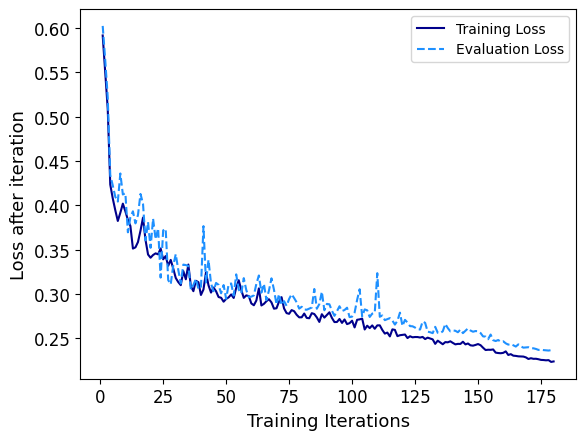

In [ ]:
# over  epochs
## plotting loss
import matplotlib.pyplot as plt
name_to_save = "losses_discriminator_cont"

epochs = list(range(1,num_epochs+1))

plt.plot(epochs, overall_loss_values, color = "darkblue")
plt.plot(epochs, overall_loss_values_eval, color = "dodgerblue", linestyle='dashed')
plt.legend(["Training Loss", "Evaluation Loss"], loc='upper right')
plt.xlabel("Training Iterations", fontsize=13)
plt.ylabel("Loss after iteration", fontsize=13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig(f'/content/gdrive/My Drive/Thesis/Plots/{name_to_save}.png')
plt.show()

In [ ]:
#fom google.colab import runtime
#runtime.unassign()


I shall now create counterfactuals with the true names:

In [ ]:
airbnb_london_filtered_images_imp_var = pd.read_csv("/content/gdrive/My Drive/Thesis/London_Data/airbnb_london_filtered_images_counterfactual_prep.csv")


In [ ]:
### saving predictions with real names

data_genrate = Simple_Dataset(airbnb_london_filtered_images_imp_var)
dl_generate_cf = DataLoader(dataset=data_genrate, collate_fn=collate_batch_extended, batch_size=64, shuffle=True)


In [ ]:
## also saving predictions with real names!
device = "cuda"

ids = []
preds_ = []
Ys = []

with torch.no_grad():
  for batch in dl_generate_cf:

    img = batch[0].to(device)
    name = torch.tensor(batch[1]).to(device)
    joint_des = torch.tensor(batch[2]).to(device)
    X = batch[3].to(device)
    Y = torch.tensor(batch[5]).to(device)
    pred = model(img, name, joint_des, X)

    ids.extend(batch[6])
    preds_.extend(pred.cpu().numpy() )

    Ys.extend(Y.cpu().numpy() )


preds = [a[0] for a in preds_ ]

pred_disc_2_cont_real_name = pd.DataFrame({"id": ids, "pred": preds, "Y": Ys})
pred_disc_2_cont_real_name.to_csv("/content/gdrive/My Drive/Thesis/Discriminator_Predictions/pred_disc_2_cont_real_name_all_2.csv", index = False)



<ipython-input-18-eace1d7752bf>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  name = torch.tensor(batch[1]).to(device)
<ipython-input-18-eace1d7752bf>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  joint_des = torch.tensor(batch[2]).to(device)
<ipython-input-12-9e2e021ad7f8>:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_des = torch.tensor(des_encoded)
<ipython-input-12-9e2e021ad7f8>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().r

### POC - Discriminator with categorical outcome

Evidently, I choose a regression model instead of a classification discriminator model.
In theory, such a model could reveal if - given a new, alternative title - the review difference count can be expected to belong to another class.

However, this was chosen against as changes in names only lead to minute changes in the expected review difference. This makes perfect sense as I am analyzing the effect of changing the names from reasonably good ones to very pleasing ones. All other features remain the same.

It is thus to be expected that almost no couterfactual review diference class would be different from the ground truth class assigned to a listing.

Nonetheless, just as a Proof of Concept, I have trained a classification model to showcase its potential in predicting review difference classes. For this, I have included all classes as the problem with very high review counts does not exist here - these just all belong to class No. 3.

In [ ]:
output_dim = 3 ## here
final_output_dim_text_name = 2
final_output_dim_text_des = 2
final_output_dim_visual = 2

model = NeuralNetwork2( model_vit, tab_input_dim, final_output_dim_visual, final_output_dim_text_name, final_output_dim_text_des, hidden_dim_1, hidden_dim_2, hidden_dim_3, hidden_dim_4, output_dim)

learning_rate = 0.003
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) ## adam

In [ ]:
from transformers import get_scheduler

accelerator = Accelerator()
model, optimizer, dl_train, dl_eval = accelerator.prepare(
    model, optimizer, dl_train, dl_eval
)

num_update_steps_per_epoch = len(dl_train)
num_epochs = 60

num_training_steps = num_epochs * num_update_steps_per_epoch


lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,     ## one might also alter this!
    num_training_steps=num_training_steps,
)


device = "cuda"
model = model.to(device)

In [ ]:

overall_loss_values = []
overall_loss_values_eval = []


progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):

  loss_values = []
  loss_values_eval = []

  model.train()

  for batch in dl_train:

    img = batch[0].to(device)
    name = torch.tensor(batch[1]).to(device)
    joint_des = torch.tensor(batch[2]).to(device)
    X = batch[3].to(device)
    Y = torch.tensor(batch[4]).to(device) ## idx of 4 here
    optimizer.zero_grad()
    pred = model(img, name, joint_des, X)
    loss = loss_fn(pred.squeeze(), Y)
    loss_values.append(loss.item())
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()
    progress_bar.update(1)

 #   print(f"mean of train loss: {str(np.mean(loss_values))}")

  model.eval()

  with torch.no_grad():
    for batch in dl_eval:

      img = batch[0].to(device)
      name = torch.tensor(batch[1]).to(device)
      joint_des = torch.tensor(batch[2]).to(device)
      X = batch[3].to(device)
      Y = torch.tensor(batch[4]).to(device)
      optimizer.zero_grad()
      pred = model(img, name, joint_des, X)
      loss = loss_fn(pred.squeeze(), Y)
      loss_values_eval.append(loss.item())


#      print(f"mean of eval loss: {str(np.mean(loss_values_eval))}")


  overall_loss_values.append(np.mean(loss_values))
  overall_loss_values_eval.append(np.mean(loss_values_eval))

  print(f"Iteration No {str(epoch + 1)}")
  print(f"Train Loss: {str(np.mean(loss_values))}")
  print(f"Eval Loss: {str(np.mean(loss_values_eval))}")
  print("---------------------")


In [ ]:
#saving the model
model_save_name = 'discriminator_2_cat.pth'

path ="/content/gdrive/My Drive/Thesis/Models/{}".format(model_save_name)
torch.save(model, path)


In [ ]:
name_to_save = "losses_disc_2_cat"
df_losses_1 = pd.DataFrame({"loss_eval": overall_loss_values_eval, "loss_train": overall_loss_values })
#df_losses_1.to_csv(f"/content/gdrive/My Drive/Thesis/loss_data/{name_to_save}.csv", index = False)

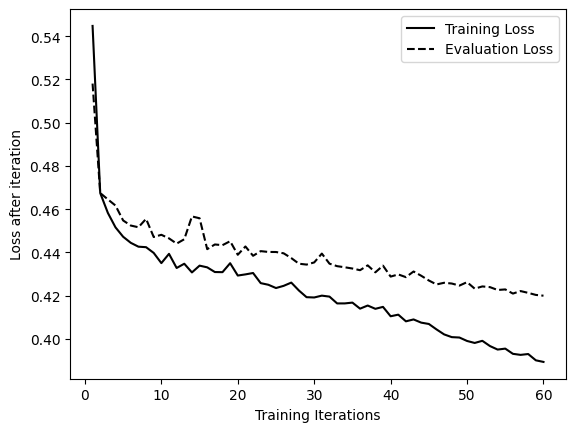

In [ ]:
# over  epochs
## plotting loss
import matplotlib.pyplot as plt
name_to_save = "losses_discriminator_2_cat"

epochs = list(range(1,num_epochs+1))

plt.plot(epochs, overall_loss_values, color = "black")
plt.plot(epochs, overall_loss_values_eval, color = "black", linestyle='dashed')
plt.legend(["Training Loss", "Evaluation Loss"], loc='upper right')
plt.xlabel("Training Iterations")
plt.ylabel("Loss after iteration")
#plt.savefig(f'/content/gdrive/My Drive/Thesis/Plots/{name_to_save}.png')
#plt.show()

In [ ]:
### obtaining classification report

argmax_labels = []
argmax_preds = []
labels = [0,1,2]

with torch.no_grad():
  for batch in dl_eval:
    X = batch[1]
    Y = torch.tensor(batch[2])
    pred = model(X)
    argmax_labels.extend( list(np.argmax(Y.numpy(), axis = 1) ))
    argmax_preds.extend( list(np.argmax(pred.numpy(), axis = 1) ))

report = classification_report(y_true=argmax_labels, y_pred=argmax_preds, labels=labels, output_dict = True)
print("Weighted Avg Classification Results:")
print(report['weighted avg'])


<ipython-input-58-b0a07fa5ec5e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(batch[2])


Weighted Avg Classification Results:
{'precision': 0.808882833782141, 'recall': 0.8317037037037037, 'f1-score': 0.8129671118121731, 'support': 6750}
